In [1]:
import pandas as pd
import numpy as np 
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
import re
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
food = pd.read_csv('./fastfood.csv', index_col=0)

In [150]:
food.head()

,Company,favorite_count,number_of_people_they_follow,number_of_user_tweets,retweet_count,text,time_tweeted,unique_code,user_coordinates,user_followers_count,user_is_verified,user_location,user_name,user_profile_text
0,@McDonalds,0.0,1559.0,776.0,0,My local @McDonalds no longer has orange HiC. ...,2018-03-13 18:01:55,973620183507128320,NaN,1254.0,0,"St. Petersburg, FL",PartsForScooters,Join us on our quest to become the best scoote...
1,@McDonalds,0.0,50.0,4.0,0,@McDonalds why did my mom leave me and move to...,2018-03-13 18:01:48,973620155514347521,NaN,2.0,0,"Hell, fuck you i live in hell",Miles Boi,"im gay and i like gay emo memes\n\n(Miles,Tran..."
2,@McDonalds,0.0,112.0,3587.0,0,@McDonalds Your company has one job. TO MAKE ...,2018-03-13 18:01:31,973620084307570689,NaN,39.0,0,NaN,buckeyes2018,Proud Veteran
3,@McDonalds,0.0,3488.0,15077.0,0,McDonald's service hits rock bottom in drive t...,2018-03-13 18:01:21,973620039470469121,NaN,5508.0,0,graham@beloved-brands.com,Beloved Brands,Graham Roberson is the Founder/CMO of Beloved ...
4,@McDonalds,0.0,74.0,909.0,0,The sauce has taken me to new heights. @McDona...,2018-03-13 18:01:05,973619976115400704,NaN,22.0,0,"San Antonio, TX",Colton,"Dogs, food and sweet tea | Clark, Tx | @brit_..."


(48294, 14)

In [4]:
food = food.drop_duplicates()

In [5]:
food.shape

(44998, 14)

In [6]:
comps = list(food.Company.unique())[:-3]
del comps[-2]
comps = [x[1:] for x in comps]

In [8]:
stopword = stopwords.words('english')
stopword.extend(comps)
stopword.extend(list(food.Company.unique())[:-3])

In [9]:
companies = list(food.Company.unique())[:-3]
texts = []
for x in companies:
    try:
        something = ' '.join(val for val in food.loc[food['Company'] == x]['text'])
        texts.append(something)
    except:
        pass
    

In [11]:
del texts[-2]

In [33]:
def Text_Cleaner(text):
    text = re.sub(r'(https)[^\s]+', '', text)
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    lower = [x.lower() for x in words]
    eliminator = [re.sub(r'(mcdon|dunki|denn|redro|sonic|starb|shakesh|domino|crackerb|chipot|wend)[a-z]+','',x)
                  for x in lower]
    portstemmer = PorterStemmer()
    porter = [portstemmer.stem(x) for x in eliminator]
    stops = [x for x in porter if x not in set(stopword)]
    lots = [x for x in stops if len(x) > 3]
    return lots

In [34]:
cleaned = [Text_Cleaner(x) for x in texts]

In [14]:
from gensim import corpora, models

In [15]:
np.random.seed(42)

In [16]:
dictionary = corpora.Dictionary(cleaned)

In [17]:
corpus = [dictionary.doc2bow(clean) for clean in cleaned]

In [18]:
ldamodel = models.ldamodel.LdaModel(corpus, 
                                    id2word = dictionary,
                                    num_topics = 7,
                                    passes = 50,
                                    minimum_probability = 0
                                   )

In [19]:
import pyLDAvis.gensim

In [20]:
x = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(x)

/Users/slevin886/anaconda2/envs/python3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


#you can update an LDA model like: 
newtext = 'some new text'
new_doc = text_process(new_text)
ldamodel.update([dictionary.doc2bow(new_doc)])

In [21]:
for i in ldamodel.print_topics(num_topics=14, num_words=5):
    print(i)

(0, '0.019*"pickl" + 0.013*"sonic" + 0.012*"slush" + 0.011*"juic" + 0.009*"corn"')
(1, '0.077*"mcdonald" + 0.055*"redrobinburg" + 0.011*"seattl" + 0.009*"burger" + 0.008*"order"')
(2, '0.045*"starbuck" + 0.044*"chipotletweet" + 0.025*"potbelli" + 0.010*"burrito" + 0.009*"order"')
(3, '0.069*"domino" + 0.021*"pizza" + 0.013*"come" + 0.012*"amarch4ourl" + 0.012*"order"')
(4, '0.104*"dennysdin" + 0.044*"denni" + 0.026*"gravi" + 0.026*"call" + 0.023*"crowd"')
(5, '0.062*"dunkindonut" + 0.059*"crackerbarrel" + 0.012*"celebr" + 0.011*"mattjackson13" + 0.010*"coffe"')
(6, '0.126*"wendi" + 0.057*"vote" + 0.046*"pick" + 0.029*"teamfresh" + 0.029*"cast"')


In [22]:
#K-Means Clustering- remember- biased heavily by outliers
#possibly use k-means ++ method in scikit learn
#k-means is not great with non-spherical data, this may not be the best case...

In [29]:
#7155 multiple tweeters out of 27528 tweeters 
food.user_name.value_counts().sort_values(ascending=False).shape


(27528,)

In [30]:
from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score

In [110]:
food.columns

Index(['Company', 'favorite_count', 'number_of_people_they_follow',
       'number_of_user_tweets', 'retweet_count', 'text', 'time_tweeted',
       'unique_code', 'user_coordinates', 'user_followers_count',
       'user_is_verified', 'user_location', 'user_name', 'user_profile_text'],
      dtype='object')

In [139]:
food['user_is_verified'] = food['user_is_verified'].astype(bool).astype(int)

In [140]:
#remember to drop these always, weird indexing...
food = food.drop(list(food.loc[food['retweet_count'] == 'False'].index))

In [141]:
cluster_quant = food.drop(['Company', 'text', 'time_tweeted', 
       'unique_code', 'user_coordinates','user_is_verified', 'user_location', 'user_name', 'user_profile_text'], axis=1)
cluster_quant.shape

(44995, 5)

In [142]:
cluster = cluster_quant.dropna()
cluster.shape

(44991, 5)

In [143]:
cluster.retweet_count = cluster.retweet_count.astype(int)

/Users/slevin886/anaconda2/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [144]:
cluster.head()

,favorite_count,number_of_people_they_follow,number_of_user_tweets,retweet_count,user_followers_count
0,0.0,1559.0,776.0,0,1254.0
1,0.0,50.0,4.0,0,2.0
2,0.0,112.0,3587.0,0,39.0
3,0.0,3488.0,15077.0,0,5508.0
4,0.0,74.0,909.0,0,22.0


In [145]:
model = KMeans(n_clusters=3, random_state=0)
model.fit(cluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [146]:
cluster['predicted'] = model.predict(cluster)

/Users/slevin886/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [147]:
cluster.retweet_count = np.log(cluster['retweet_count'].values)
cluster.favorite_count = np.log(cluster['favorite_count'].values)

/Users/slevin886/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.
/Users/slevin886/anaconda2/envs/python3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/slevin886/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


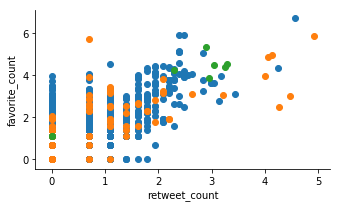

In [148]:
plt.figure(figsize=(15,25))
fg = sns.FacetGrid(data=cluster, hue='predicted', aspect=1.61)
fg.map(plt.scatter, 'retweet_count', 'favorite_count')

In [149]:
#it is useful to scale before clustering
#to optimize k, use the elbow method (inertia vs. silhouette score)

In [137]:
#play more later...
predicted = model.labels_
inertia = model.inertia_
score = silhouette_score(cluster, predicted)
inertia, score

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').